In [1]:
import pandas as pd
import ast
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
from itertools import product
import missingno as msno

In [2]:
# df = pd.read_csv("output/aggregated/df_annotations.csv")
df = pd.read_csv("output/aggregated/df_annotations_validated.csv")

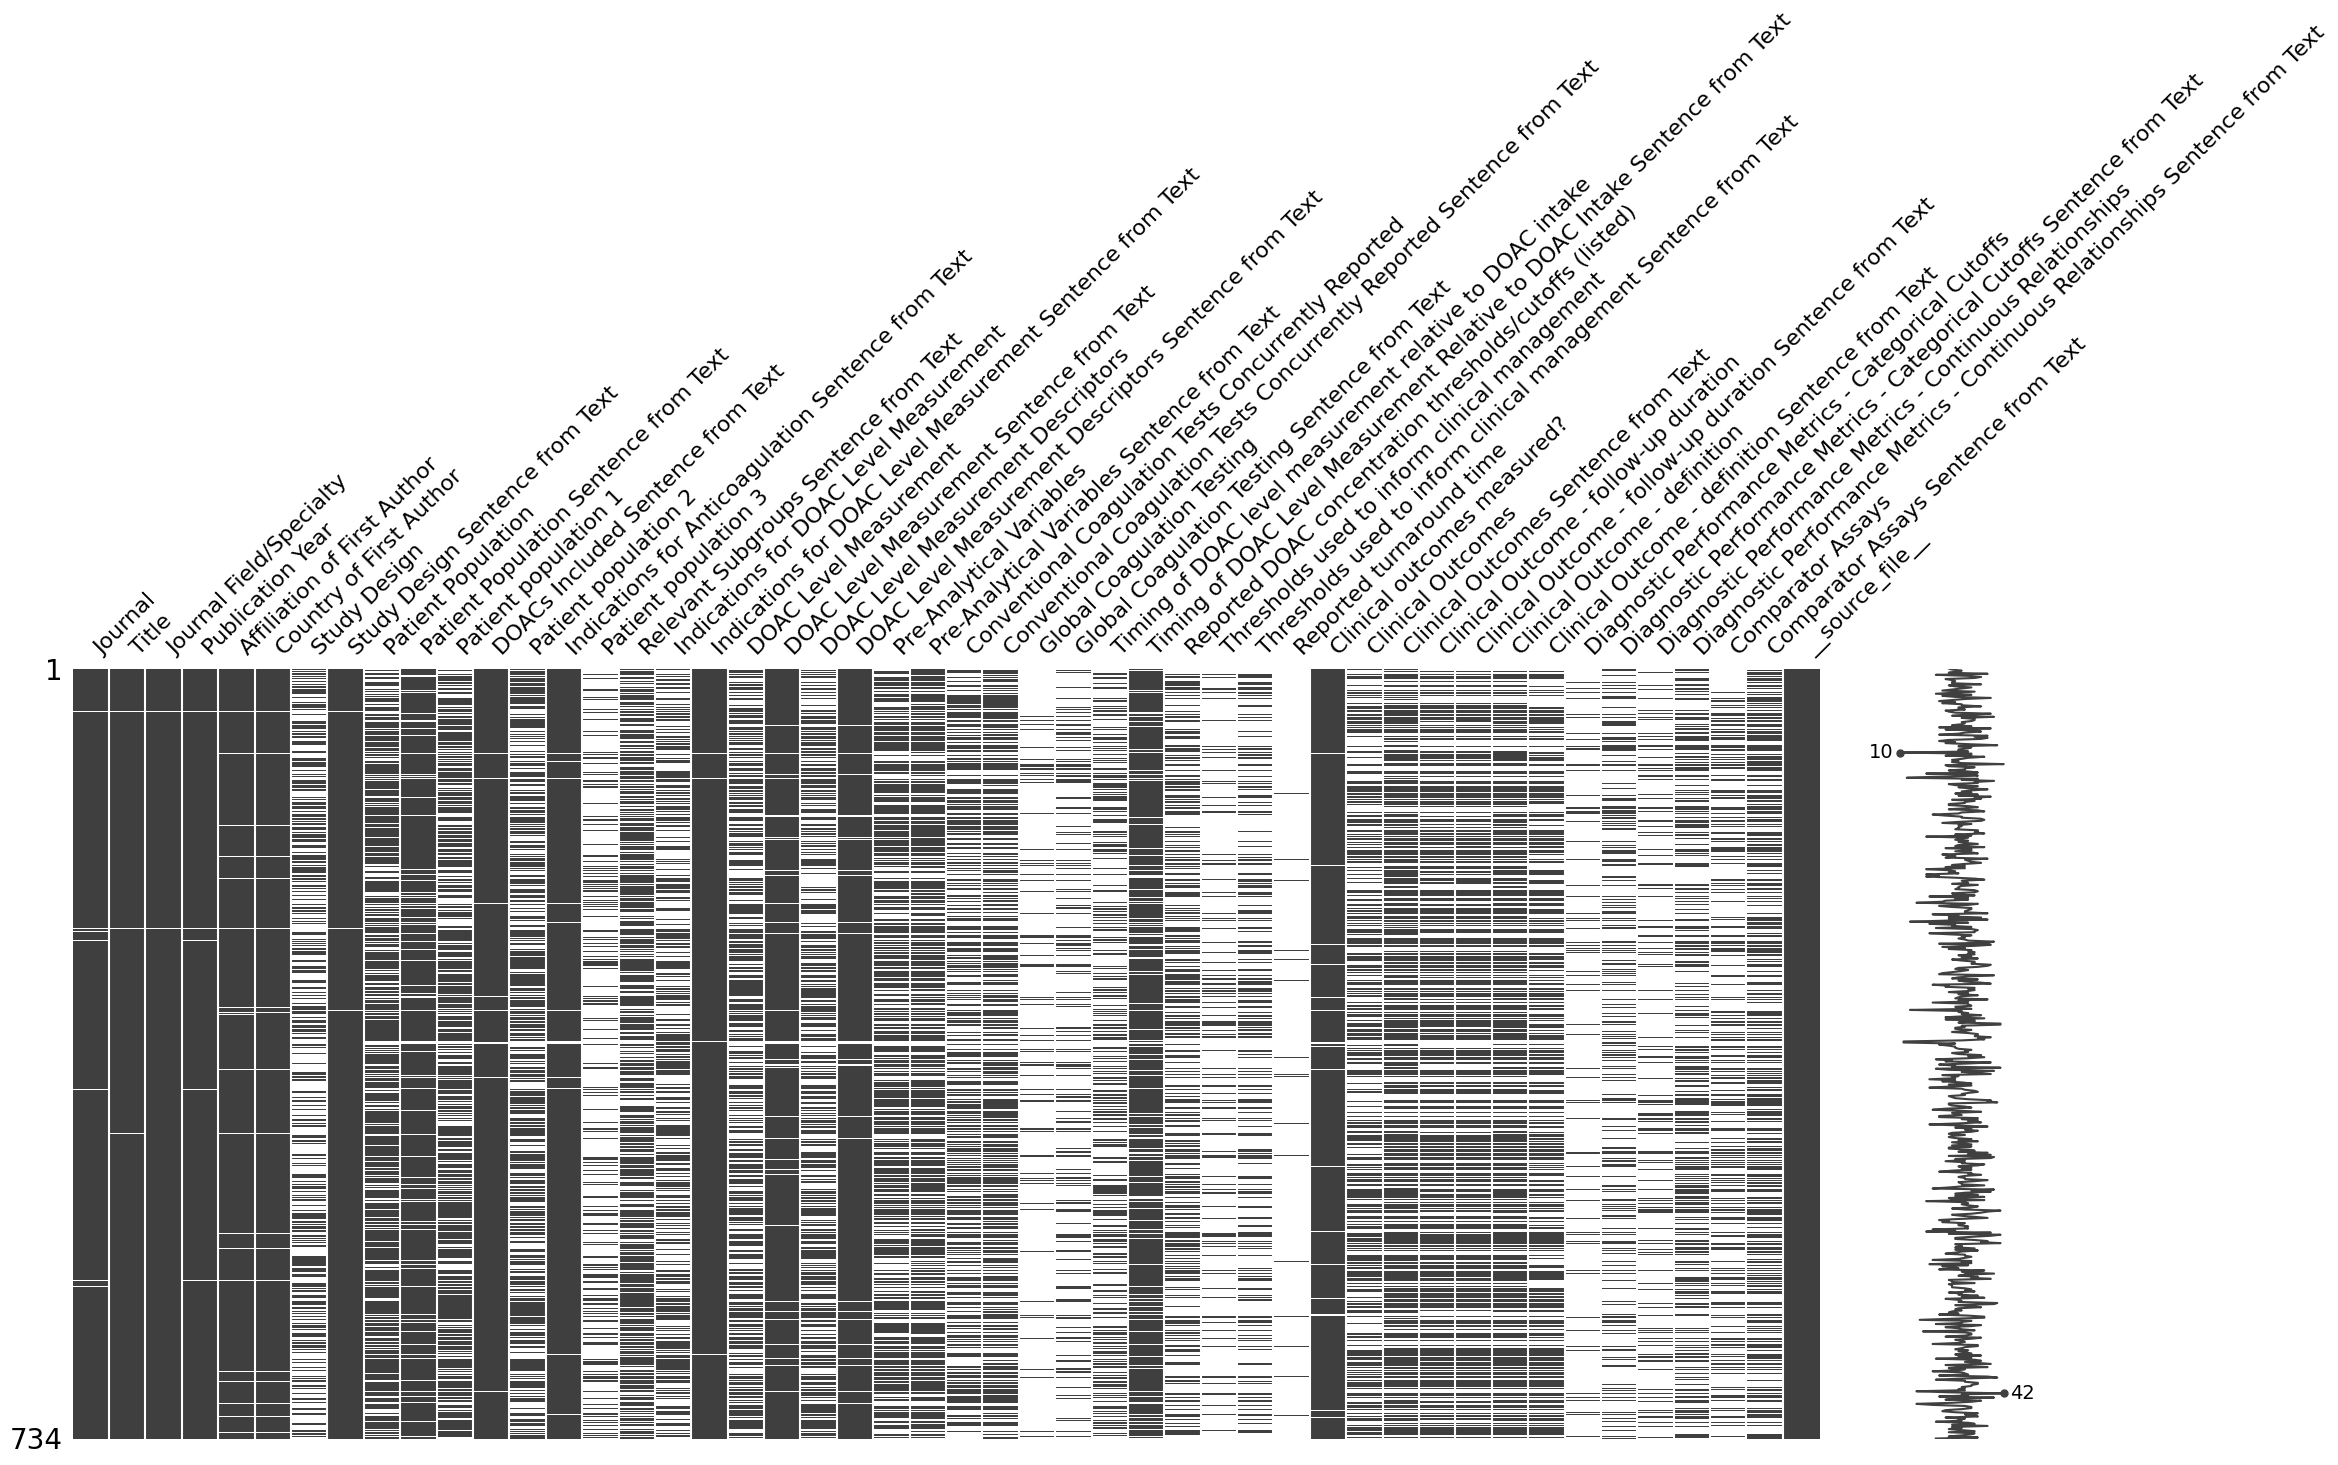

In [3]:
msno.matrix(df);

In [4]:
def is_list_like(x):
    """Safely check if x represents or is a list."""
    if isinstance(x, list):
        return True
    if isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            return isinstance(val, list)
        except (ValueError, SyntaxError):
            return False
    return False

In [5]:
list_like_cols = [col for col in df.columns if df[col].dropna().apply(is_list_like).all()]

for col in list_like_cols:
    df[col] = df[col].apply(lambda x: eval(x) if is_list_like(x) else x)

In [6]:
# df_unraveled = df.copy()
# for c in list_like_cols:
#     df_unraveled = df_unraveled.explode(c, ignore_index=True)

In [7]:
# df.to_csv("output/aggregated/df_annotations_v2.csv", index=False)
df.to_csv("output/aggregated/df_annotations_v2_validated.csv", index=False)

In [8]:
out_folder = "output/charts_and_excels"
sheet = "Data"

In [9]:
from itertools import product

def mix_two_columns(df, col1, col2, list_like_cols):
    insert_at = df.columns.get_loc(col2)
    new_col = f'{col2}_stratified'
    
    for i, row in df.iterrows():
        if isinstance(row[col1], list) and isinstance(row[col2], list):
            mix = list(product(row[col1], row[col2]))
            df.at[i, f'{col2}_stratified'] = [i + ' - ' + j for i, j in mix]
        else:
            df.at[i, f'{col2}_stratified'] = pd.NA
    
    col = df.pop(new_col)
    df.insert(insert_at, new_col, col)
    df.drop(columns=[col2], inplace=True)
    
    list_like_cols.append(new_col)
    list_like_cols.remove(col2)
    
    return df, list_like_cols

df, list_like_cols = mix_two_columns(df, 'Patient population 1', 'Conventional Coagulation Tests Concurrently Reported', list_like_cols)
df, list_like_cols = mix_two_columns(df, 'Patient population 1', 'Global Coagulation Testing', list_like_cols)

In [10]:
def sanitize_sheet_name(name: str) -> str:
    name = re.sub(r"[\[\]\:\*\?\/\\]", "_", str(name))
    name = name.strip("'")
    return (name[:31].strip() or "Sheet")

def make_unique_sheet_name(base: str, taken_lower: set) -> str:
    base = sanitize_sheet_name(base)
    name = base
    i = 1
    while name.lower() in taken_lower:
        suffix = f"_{i}"
        room = 31 - len(suffix)
        name = (base[:room] if room > 0 else "Sheet") + suffix
        i += 1
    taken_lower.add(name.lower())
    return name

def _dedup_within_cell(x):
    """
    For list-like cells, drop duplicates per row while preserving order.
    Non list-like values are returned as-is.
    """
    if isinstance(x, list):
        return list(dict.fromkeys(x))
    if isinstance(x, tuple):
        return list(dict.fromkeys(x))
    if isinstance(x, set):
        # sets are already unique but unordered; convert to list
        return list(x)
    return x

def save_value_counts_charts(
    df: pd.DataFrame,
    list_like_cols=None,
    out_path: str = "output/charts_and_excels/df_distributions.xlsx",
    min_count: int = 3,
    skip_cols: list[str] = ("Title", "__source_file__")
):
    if list_like_cols is None:
        list_like_cols = []

    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)

    with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
        workbook = writer.book
        taken_lower = set()

        for col in tqdm(df.columns):
            # skip exact names OR columns ending with "sentence from text"
            if (col in skip_cols) or col.lower().endswith("sentence from text"):
                continue
            
            # deduplicate within cell
            if col in list_like_cols:
                series = df[col].apply(_dedup_within_cell).explode()
            else:
                series = df[col]

            # value counts (full — for the sheet)
            series = df[col].explode() if col in list_like_cols else df[col]
            vc_full = series.dropna().value_counts()

            if vc_full.empty:
                continue

            # filtered — only for charting
            vc_chart = vc_full[vc_full.values > min_count]
            n_chart = len(vc_chart)

            # write the FULL table
            dist_df_full = vc_full.rename_axis("Value").reset_index(name="Frequency")
            sheet_name = make_unique_sheet_name(col, taken_lower)
            dist_df_full.to_excel(writer, sheet_name=sheet_name, index=False)
            worksheet = writer.sheets[sheet_name]

            # only add a chart if we have anything over the threshold
            if n_chart > 0:
                chart = workbook.add_chart({"type": "column"})
                # Because value_counts() is descending, the >min rows are the top n_chart rows
                categories_ref = [sheet_name, 1, 0, n_chart, 0]  # A2:A{n_chart+1}
                values_ref     = [sheet_name, 1, 1, n_chart, 1]  # B2:B{n_chart+1}

                chart.add_series({
                    "name": f"Distribution of {col} (> {min_count})",
                    "categories": categories_ref,
                    "values": values_ref,
                    "data_labels": {"value": True},
                })
                chart.set_title({"name": f"Distribution of {col} (> {min_count})"})
                chart.set_x_axis({"name": "Value"})
                chart.set_y_axis({"name": "Frequency"})
                chart.set_style(10)

                worksheet.insert_chart("D2", chart, {"x_scale": 1.3, "y_scale": 1.2})

    print(f"✅ Excel file saved at: {out_path}")

In [11]:
save_value_counts_charts(
    df,
    list_like_cols=list_like_cols,
    # out_path="output/charts_and_excels/df_distributions.xlsx",
    out_path="output/charts_and_excels/df_distributions_validated.xlsx",
    min_count=3,
    skip_cols=("Title")
)

100%|██████████| 48/48 [00:00<00:00, 624.22it/s]


✅ Excel file saved at: output/charts_and_excels/df_distributions_validated.xlsx
